In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 设定随机种子
torch.manual_seed(2017)

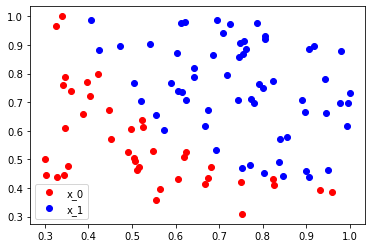

In [3]:
# 从 data.txt 中读入点
with open('./data.txt', 'r') as f:
    data_list = [i.split('\n')[0].split(',') for i in f.readlines()]
    data = [(float(i[0]), float(i[1]), float(i[2])) for i in data_list]

# 标准化
x0_max = max([i[0] for i in data])
x1_max = max([i[1] for i in data])
data = [(i[0]/x0_max, i[1]/x1_max, i[2]) for i in data]

x0 = list(filter(lambda x: x[-1] == 0.0, data)) # 选择第一类的点
x1 = list(filter(lambda x: x[-1] == 1.0, data)) # 选择第二类的点

plot_x0 = [i[0] for i in x0]
plot_y0 = [i[1] for i in x0]
plot_x1 = [i[0] for i in x1]
plot_y1 = [i[1] for i in x1]

plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

In [4]:
np_data = np.array(data, dtype='float32') # 转换成 numpy array
x_data = torch.from_numpy(np_data[:, 0:2]) # 转换成 Tensor, 大小是 [100, 2]
y_data = torch.from_numpy(np_data[:, -1]).unsqueeze(1) # 转换成 Tensor，大小是 [100, 1]

In [5]:
import torch.nn.functional as F

# 定义 logistic 回归模型
w = torch.randn(2, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def logistic_regression(x):
    return F.sigmoid(torch.mm(x, w) + b)

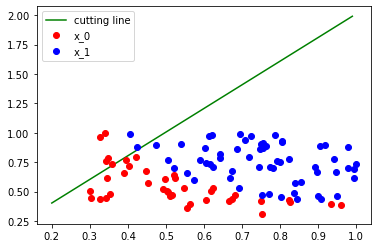

In [6]:
# 画出参数更新之前的结果
w0 = w[0].item()
w1 = w[1].item()
b0 = b.item()

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (-w0 * plot_x - b0) / w1

plt.plot(plot_x, plot_y, 'g', label='cutting line')
plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

In [7]:
# 计算loss 交叉熵
def binary_loss(y_pred, y):
    logits = (y * y_pred.clamp(1e-12).log() + (1 - y) * (1 - y_pred).clamp(1e-12).log()).mean()
    return -logits

In [8]:
y_pred = logistic_regression(x_data)
loss = binary_loss(y_pred, y_data)
print(loss)

tensor(0.6412, grad_fn=<NegBackward>)


/usr/local/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [9]:
# 自动求导并更新参数
loss.backward()
w.data = w.data - 0.1 * w.grad.data
b.data = b.data - 0.1 * b.grad.data

# 算出一次更新之后的loss
y_pred = logistic_regression(x_data)
loss = binary_loss(y_pred, y_data)
print(loss)

tensor(0.6407, grad_fn=<NegBackward>)


In [10]:
# 使用 torch.optim 更新参数
from torch import nn
w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

def logistic_regression(x):
    return F.sigmoid(torch.mm(x, w) + b)

optimizer = torch.optim.SGD([w, b], lr=1.)

In [12]:
# 进行 1000 次更新
import time

start = time.time()
for e in range(1000):
    # 前向传播
    y_pred = logistic_regression(x_data)
    loss = binary_loss(y_pred, y_data) # 计算 loss
    # 反向传播
    optimizer.zero_grad() # 使用优化器将梯度归 0
    loss.backward()
    optimizer.step() # 使用优化器来更新参数
    # 计算正确率
    mask = y_pred.ge(0.5).float()
    acc = (mask == y_data).sum().item() / y_data.shape[0]
    if (e + 1) % 200 == 0:
        print('epoch: {}, Loss: {:.5f}, Acc: {:.5f}'.format(e+1, loss.item(), acc))
during = time.time() - start
print()
print('During Time: {:.3f} s'.format(during))

epoch: 200, Loss: 0.39672, Acc: 0.92000
epoch: 400, Loss: 0.32435, Acc: 0.92000
epoch: 600, Loss: 0.29053, Acc: 0.91000
epoch: 800, Loss: 0.27069, Acc: 0.91000
epoch: 1000, Loss: 0.25759, Acc: 0.90000

During Time: 0.476 s


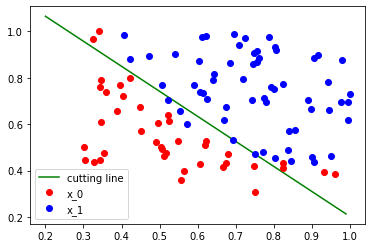

In [14]:
# 画出更新之后的结果
w0 = w[0].item()
w1 = w[1].item()
b0 = b.item()

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (-w0 * plot_x - b0) / w1

plt.plot(plot_x, plot_y, 'g', label='cutting line')
plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

In [15]:
# 使用自带的loss
criterion = nn.BCEWithLogitsLoss() # 将 sigmoid 和 loss 写在一层，有更快的速度、更好的稳定性

w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

def logistic_reg(x):
    return torch.mm(x, w) + b

optimizer = torch.optim.SGD([w, b], 1.)

In [16]:
y_pred = logistic_reg(x_data)
loss = criterion(y_pred, y_data)
print(loss.data)

tensor(0.6363)


In [17]:
# 同样进行 1000 次更新

start = time.time()
for e in range(1000):
    # 前向传播
    y_pred = logistic_reg(x_data)
    loss = criterion(y_pred, y_data)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 计算正确率
    mask = y_pred.ge(0.5).float()
    acc = (mask == y_data).sum().item() / y_data.shape[0]
    if (e + 1) % 200 == 0:
        print('epoch: {}, Loss: {:.5f}, Acc: {:.5f}'.format(e+1, loss.item(), acc))

during = time.time() - start
print()
print('During Time: {:.3f} s'.format(during))

epoch: 200, Loss: 0.39538, Acc: 0.88000
epoch: 400, Loss: 0.32407, Acc: 0.87000
epoch: 600, Loss: 0.29039, Acc: 0.87000
epoch: 800, Loss: 0.27061, Acc: 0.87000
epoch: 1000, Loss: 0.25753, Acc: 0.88000

During Time: 0.270 s
